# Домашнє завдання: ETL-пайплайни для аналітиків даних

Це ДЗ передбачене під виконання на локальній машині. Виконання з Google Colab буде суттєво ускладнене.

## Підготовка
1. Переконайтесь, що у вас встановлены необхідні бібліотеки:
   ```bash
   pip install sqlalchemy pymysql pandas matplotlib seaborn python-dotenv
   ```

2. Створіть файл `.env` з параметрами підключення до бази даних classicmodels. Базу даних ви можете отримати через

  - docker-контейнер згідно існтрукції в [документі](https://www.notion.so/hannapylieva/Docker-1eb94835849480c9b2e7f5dc22ee4df9), також відео інструкції присутні на платформі - уроки "MySQL бази, клієнт для роботи з БД, Docker і ChatGPT для запитів" та "Як встановити Docker для роботи з базами даних без терміналу"
  - або встановивши локально цю БД - для цього перегляньте урок "Опціонально. Встановлення MySQL та  БД Сlassicmodels локально".
  
  Приклад `.env` файлу ми створювали в лекції. Ось його обовʼязкове наповнення:
    ```
    DB_HOST=your_host
    DB_PORT=3306 або 3307 - той, який Ви налаштували
    DB_USER=your_username
    DB_PASSWORD=your_password
    DB_NAME=classicmodels
    ```
  Якщо ви створили цей файл під час перегляду лекції - **новий створювати не треба**. Замініть лише назву БД, або пропишіть назву в коді створення підключення (замість отримання назви цільової БД зі змінних оточення). Але переконайтесь, що до `.env` файл лежить в тій самій папці, що і цей ноутбук.

  **УВАГА!** НЕ копіюйте скрит для **створення** `.env` файлу. В лекції він наводиться для прикладу. І давалось пояснення, що в реальних проєктах ми НІКОЛИ не пишемо доступи до бази в коді. Копіювання скрипта для створення `.env` файлу сюди в ДЗ буде вважатись грубою помилкою і ми зніматимемо бали.

3. Налаштуйте підключення через SQLAlchemy до БД за прикладом в лекції.

Рекомендую вивести (відобразити) змінну engine після створення. Вона має бути не None! Якщо None - значить у Вас не підтягнулись налаштування з .env файла.

Ви також можете налаштувати параметри підключення до БД без .env файла, просто прописавши текстом в відповідних місцях. Це - не рекомендований підхід.

In [8]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as sa
import requests
import datetime
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

In [3]:
# Підключення до БД
def create_connection():
    load_dotenv()

    host = os.getenv('DB_HOST')
    port = os.getenv('DB_PORT', '3306')
    user = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    database = os.getenv('DB_NAME')

    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}"

    engine = create_engine(
        connection_string,
        pool_size=1,
        max_overflow=20,
        pool_pre_ping=True,
        echo=False
    )

    return engine

engine = create_connection()

### Завдання 1: Створення таблиці курсів валют та API інтеграція (2 бали)

**Повторіть процедуру з лекції:** створіть таблицю для курсів валют, але вже в цій базі даних. Результатом має бути нова таблиця з курсами валют USD, EUR, UAH в БД (можна завантажити більше валют). Продемонструйте, що таблиця була додана, використовуючи SELECT.

Тобто тут ви можете прямо скопіювати код з лекції, внести необхідні зміни і запустити. Головне - отримати таблицю в БД classicmodels.

In [9]:
# 1. Створення таблиці currency_rates
def create_currency_table(engine):
    create_table_sql = text("""
    CREATE TABLE IF NOT EXISTS currency_rates (
        id INT AUTO_INCREMENT PRIMARY KEY,
        currency_code VARCHAR(3) NOT NULL,
        rate_to_usd DECIMAL(10, 6) NOT NULL,
        rate_date DATE NOT NULL,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP,
        INDEX idx_currency_date (currency_code, rate_date),
        UNIQUE KEY unique_currency_date (currency_code, rate_date)
    )
    """)

    with engine.connect() as conn:
        conn.execute(create_table_sql)

    print("Таблиця 'currency_rates' створена")

# 2. Отримання курсів валют через API
def fetch_exchange_rates():
    try:
        url = "https://api.exchangerate-api.com/v4/latest/USD"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        currencies = ['EUR', 'GBP', 'UAH', 'PLN', 'JPY']
        rates = {}

        for currency in currencies:
            if currency in data['rates']:
                rates[currency] = data['rates'][currency]

        return rates, datetime.date.today()

    except Exception as e:
        print(f"❌ Помилка при отриманні API: {e}")
        return None, None

# 3. Збереження курсів у таблицю
def save_exchange_rates(engine, rates_dict, rate_date):
    if not rates_dict:
        print("❌ Немає даних для збереження")
        return False

    insert_sql = text("""
    INSERT INTO currency_rates (currency_code, rate_to_usd, rate_date)
    VALUES (:currency, :rate, :date)
    ON DUPLICATE KEY UPDATE
        rate_to_usd = VALUES(rate_to_usd),
        updated_at = CURRENT_TIMESTAMP
    """)

    try:
        with engine.connect() as conn:
            with conn.begin():
                for currency, rate in rates_dict.items():
                    conn.execute(insert_sql, {
                        'currency': currency,
                        'rate': rate,
                        'date': rate_date
                    })
        print(f"Збережено {len(rates_dict)} курсів валют на {rate_date}")
        return True

    except Exception as e:
        print(f"❌ Помилка збереження: {e}")
        return False

# === Виконання процесу ===
create_currency_table(engine)

print("Отримуємо курси валют...")
rates, date = fetch_exchange_rates()

if rates:
    print(f"Отримані курси на {date}:")
    for currency, rate in rates.items():
        print(f"  1 USD = {rate:.4f} {currency}")

    if save_exchange_rates(engine, rates, date):
        # 4. SELECT для перевірки
        df = pd.read_sql("SELECT * FROM currency_rates ORDER BY created_at DESC LIMIT 10", engine)
        print("\n📋 Останні збережені записи:")
        print(df)


Таблиця 'currency_rates' створена
Отримуємо курси валют...
Отримані курси на 2025-08-01:
  1 USD = 0.8750 EUR
  1 USD = 0.7570 GBP
  1 USD = 41.7100 UAH
  1 USD = 3.7400 PLN
  1 USD = 150.4000 JPY
Збережено 5 курсів валют на 2025-08-01

📋 Останні збережені записи:
   id currency_code  rate_to_usd   rate_date          created_at  \
0   1           EUR        0.875  2025-08-01 2025-08-01 15:45:24   
1   2           GBP        0.757  2025-08-01 2025-08-01 15:45:24   
2   3           UAH       41.710  2025-08-01 2025-08-01 15:45:24   
3   4           PLN        3.740  2025-08-01 2025-08-01 15:45:24   
4   5           JPY      150.400  2025-08-01 2025-08-01 15:45:24   

           updated_at  
0 2025-08-01 15:59:51  
1 2025-08-01 15:59:51  
2 2025-08-01 15:59:51  
3 2025-08-01 15:59:51  
4 2025-08-01 15:59:51  


# Завдання 2: Створення простого ETL пайплайну (7 балів)

В цьому завданні ми створимо повноцінний ETL процес для аналізу продажів ClassicModels.

Завдання обʼємне і оцінюється відповідно. Ви можете пропустити обчислення якихось з метрик, якщо відчуєте, що вже немає сил робити це завдання. Бал буде виставлено виходячи з виконаного обʼєму та його правильності.

## Що саме треба зробити:

### Extract (Витягування даних):
На цьому етапі треба витягнути дані з БД в pandas.DataFrame для подальшої обробки.
Які дані нам потрібні (кожен пункт - в окремий фрейм даних):
1. **дані про виконані замовлення за 2004 рік** - з'єднати таблиці orders, orderdetails, products, customers
2. **дані про продукти** - назви, категорії, ціни
3. **дані про курси валют** - використати дані з попереднього завдання

### Transform (Обробка даних):

#### 2.1 Додати розрахункові колонки до основної таблиці:
Додайте до DataFrame з продажами такі нові колонки:

- **`profit_per_item`** - прибуток з одного товару (використайте колонки: `priceEach` - `buyPrice`)
- **`total_profit`** - загальний прибуток з товарної позиції (використайте колонки: `profit_per_item` × `quantityOrdered`)
- **`total_amount_eur`** - сума в євро (використайте колонки: `total_amount` / `eur_rate`)

#### 2.2 Створити аналітичну таблицю по країнах (ТОП-5):
Згрупуйте дані по колонці **`country`** та обчисліть для кожної країни:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з 5 найприбутковіших країн, відсортована за загальним доходом (від більшого до меншого).

#### 2.3 Створити аналітичну таблицю по продуктових лініях:
Згрупуйте дані по колонці **`productLine`** та обчисліть ті ж метрики:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з усіма продуктовими лініями, відсортована за загальним доходом.

#### 2.4 Створити підсумкову інформацію (Executive Summary):
Розрахуйте загальні показники бізнесу за 2004 рік:

**Фінансові показники:**
- **Загальний дохід в доларах** - сума всієї колонки `total_amount`
- **Загальний дохід в євро** - сума всієї колонки `total_amount_eur`
- **Загальний прибуток в доларах** - сума всієї колонки `total_profit`
- **Загальна маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100
- **Середній розмір замовлення** - середнє значення колонки `total_amount`

**Операційні показники:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Кількість унікальних клієнтів** - унікальні значення колонки `customerName`
- **Період даних** - мінімальна та максимальна дата з колонки `orderDate`

**Топ показники:**
- **Найприбутковіша країна** - перший рядок з таблиці країн (колонка `country`)
- **Найприбутковіша продуктова лінія** - перший рядок з таблиці продуктів (колонка `productLine`)

### Load (Збереження результатів):
В цій частині ми зберігаємо результати наших обчислень.
Використайте приклади коду з лекцій та адаптуйте його під цей ETL процес.
Що Вам потрібно створити:

#### 3.1 Excel файл з трьома вкладками:
- **"Summary"** - підсумкова інформація у вигляді таблиці "Показник - Значення"
- **"Top_Countries"** - аналітика по топ-5 країнах
- **"Product_Lines"** - аналітика по всіх продуктових лініях

#### 3.2 Візуалізація:
- Створіть стовпчикову діаграму топ-5 країн за доходом.
- Створіть pie chart з відсотковим розподілом доходу в USD по продуктових лінійках.

## РЕКОМЕНДАЦІЇ ДО ВИКОНАННЯ:

### Покрокова стратегія виконання:
1. Спочатку протестуйте Extract просто в Jupyter notebook (без фукнції) - переконайтеся що SQL запит працює і повертає дані за 2004 рік
2. Потім протестуйте кожен Transform окремо - виведіть проміжні результати
3. Нарешті протестуйте Load - перевірте що файли створюються правильно  
4. Тільки після цього обгортайте все в функцію

### Як перевірити що все працює:
- Виводьте на екран, який етап зараз відбувається
- Виведіть кількість записів після кожного кроку
- Покажіть перші 5 рядків кожної аналітичної таблиці
- Перевірте що дати належать 2004 року
- Переконайтеся що маржа прибутку в розумних межах (0-50%)

In [12]:
# 1.1 Продажі за 2004 рік

query_sales_2004 = """
SELECT 
    o.orderNumber,
    o.orderDate,
    od.productCode,
    od.quantityOrdered,
    od.priceEach,
    p.productName,
    p.buyPrice,
    p.productLine,
    c.customerNumber,
    c.customerName,
    c.country
FROM orders o
JOIN orderdetails od ON o.orderNumber = od.orderNumber
JOIN products p ON od.productCode = p.productCode
JOIN customers c ON o.customerNumber = c.customerNumber
WHERE YEAR(o.orderDate) = 2004
"""
sales_df = pd.read_sql(text(query_sales_2004), con=engine)
print("Продажі за 2004 рік:", sales_df.shape)
print(sales_df.head())


Продажі за 2004 рік: (1421, 11)
   orderNumber   orderDate productCode  quantityOrdered  priceEach  \
0        10345  2004-11-25    S24_2022               43      38.98   
1        10298  2004-09-27    S18_2625               32      60.57   
2        10298  2004-09-27    S10_2016               39     105.86   
3        10346  2004-11-29    S24_3969               22      38.57   
4        10278  2004-08-06    S24_3856               25     136.22   

                                 productName  buyPrice   productLine  \
0  1938 Cadillac V-16 Presidential Limousine     20.61  Vintage Cars   
1        1936 Harley Davidson El Knucklehead     24.23   Motorcycles   
2                      1996 Moto Guzzi 1100i     68.99   Motorcycles   
3           1936 Mercedes Benz 500k Roadster     21.75  Vintage Cars   
4                    1956 Porsche 356A Coupe     98.30  Classic Cars   

   customerNumber        customerName country  
0             103   Atelier graphique  France  
1             103 

In [17]:
# 1.2 Продукти (назва, категорія, ціна)

query_products = """
SELECT 
    productCode,
    productName,
    productLine,
    buyPrice,
    MSRP
FROM products
"""
products_df = pd.read_sql(text(query_products), con=engine)
print("Продукти:", products_df.shape)
print(products_df.head())


Продукти: (110, 5)
  productCode                            productName   productLine  buyPrice  \
0    S10_1678  1969 Harley Davidson Ultimate Chopper   Motorcycles     48.81   
1    S10_1949               1952 Alpine Renault 1300  Classic Cars     98.58   
2    S10_2016                  1996 Moto Guzzi 1100i   Motorcycles     68.99   
3    S10_4698   2003 Harley-Davidson Eagle Drag Bike   Motorcycles     91.02   
4    S10_4757                    1972 Alfa Romeo GTA  Classic Cars     85.68   

     MSRP  
0   95.70  
1  214.30  
2  118.94  
3  193.66  
4  136.00  


In [19]:
# 1.3 Курси валют (з попередньої таблиці currency_rates)

query_currency = """
SELECT currency_code, rate_to_usd, rate_date 
FROM currency_rates
WHERE rate_date = '2025-08-01'
"""
currency_df = pd.read_sql(text(query_currency), con=engine)
print("Курси валют:", currency_df.shape)
print(currency_df)



Курси валют: (5, 3)
  currency_code  rate_to_usd   rate_date
0           EUR        0.875  2025-08-01
1           GBP        0.757  2025-08-01
2           UAH       41.710  2025-08-01
3           PLN        3.740  2025-08-01
4           JPY      150.400  2025-08-01


In [21]:
# 2.1 Додаємо розрахункові колонки

eur_rate = float(currency_df[currency_df['currency_code'] == 'EUR']['rate_to_usd'].values[0])

sales_df['profit_per_item'] = sales_df['priceEach'] - sales_df['buyPrice']
sales_df['total_profit'] = sales_df['profit_per_item'] * sales_df['quantityOrdered']
sales_df['total_amount'] = sales_df['priceEach'] * sales_df['quantityOrdered']
sales_df['total_amount_eur'] = sales_df['total_amount'] / eur_rate

print(sales_df[['orderNumber', 'productCode', 'total_amount', 'total_profit', 'total_amount_eur']].head())


   orderNumber productCode  total_amount  total_profit  total_amount_eur
0        10345    S24_2022       1676.14        789.91       1915.588571
1        10298    S18_2625       1938.24       1162.88       2215.131429
2        10298    S10_2016       4128.54       1437.93       4718.331429
3        10346    S24_3969        848.54        370.04        969.760000
4        10278    S24_3856       3405.50        948.00       3892.000000


In [23]:
# 2.2. Створюємо аналітичну таблицю по країнах (ТОП-5):
top_countries = sales_df.groupby('country').agg(
    unique_orders=('orderNumber', 'nunique'),
    total_revenue=('total_amount', 'sum'),
    total_profit=('total_profit', 'sum'),
    total_quantity=('quantityOrdered', 'sum')
).reset_index()

top_countries['profit_margin_%'] = (top_countries['total_profit'] / top_countries['total_revenue']) * 100
top_countries = top_countries.sort_values(by='total_revenue', ascending=False).head(5)

print("ТОП-5 країн:")
print(top_countries)


ТОП-5 країн:
        country  unique_orders  total_revenue  total_profit  total_quantity  \
20          USA             53     1526499.65     614370.08           16719   
6        France             19      506660.01     211528.15            5632   
16        Spain             14      439881.84     175328.56            4962   
19           UK              7      238193.93      93425.03            2778   
11  New Zealand              6      233362.27      94390.14            2537   

    profit_margin_%  
20        40.246985  
6         41.749525  
16        39.858104  
19        39.222255  
11        40.447901  


In [27]:
# 2.3. Створюємо аналітичну таблицю по продуктових лініях:

product_lines = sales_df.groupby('productLine').agg(
    unique_orders=('orderNumber', 'nunique'),
    total_revenue=('total_amount', 'sum'),
    total_profit=('total_profit', 'sum'),
    total_quantity=('quantityOrdered', 'sum')
).reset_index()

product_lines['profit_margin_%'] = (product_lines['total_profit'] / product_lines['total_revenue']) * 100
product_lines = product_lines.sort_values(by='total_revenue', ascending=False)

print(" Продуктові лінії:")
print(product_lines)


 Продуктові лінії:
        productLine  unique_orders  total_revenue  total_profit  \
0      Classic Cars             97     1763136.73     703837.29   
6      Vintage Cars             88      854551.85     350298.70   
1       Motorcycles             37      527243.84     222485.41   
2            Planes             34      471971.46     182273.04   
5  Trucks and Buses             40      465390.00     182082.20   
3             Ships             35      337326.10     134731.87   
4            Trains             22       96285.53      33672.63   

   total_quantity  profit_margin_%  
0           16085        39.919609  
6           10864        40.992094  
1            5976        42.197821  
2            5820        38.619505  
5            5024        39.124648  
3            4309        39.941134  
4            1409        34.971641  


In [28]:
# 2.4 Створити підсумкову інформацію (Executive Summary):
summary = {
    "Загальний дохід (USD)": sales_df['total_amount'].sum(),
    "Загальний дохід (EUR)": sales_df['total_amount_eur'].sum(),
    "Загальний прибуток (USD)": sales_df['total_profit'].sum(),
    "Маржа прибутку (%)": (sales_df['total_profit'].sum() / sales_df['total_amount'].sum()) * 100,
    "Середній розмір замовлення (USD)": sales_df.groupby('orderNumber')['total_amount'].sum().mean(),
    "К-сть унікальних замовлень": sales_df['orderNumber'].nunique(),
    "К-сть унікальних клієнтів": sales_df['customerName'].nunique(),
    "Період": f"{sales_df['orderDate'].min()} — {sales_df['orderDate'].max()}",
    "ТОП країна": top_countries.iloc[0]['country'],
    "ТОП продуктова лінія": product_lines.iloc[0]['productLine']
}
summary_df = pd.DataFrame(list(summary.items()), columns=['Показник', 'Значення'])

print(" Summary:")
print(summary_df)


 Summary:
                           Показник                 Значення
0             Загальний дохід (USD)               4515905.51
1             Загальний дохід (EUR)           5161034.868571
2          Загальний прибуток (USD)               1809381.14
3                Маржа прибутку (%)                40.066851
4  Середній розмір замовлення (USD)             29906.659007
5        К-сть унікальних замовлень                      151
6         К-сть унікальних клієнтів                       89
7                            Період  2004-01-02 — 2004-12-17
8                        ТОП країна                      USA
9              ТОП продуктова лінія             Classic Cars


In [32]:
# 3.1. Excel файл з трьома вкладками:

with pd.ExcelWriter("classicmodels_sales_analysis.xlsx") as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    top_countries.to_excel(writer, sheet_name="Top_Countries", index=False)
    product_lines.to_excel(writer, sheet_name="Product_Lines", index=False)


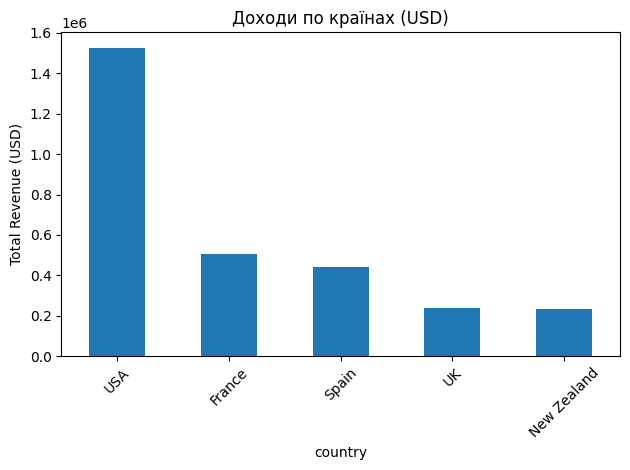

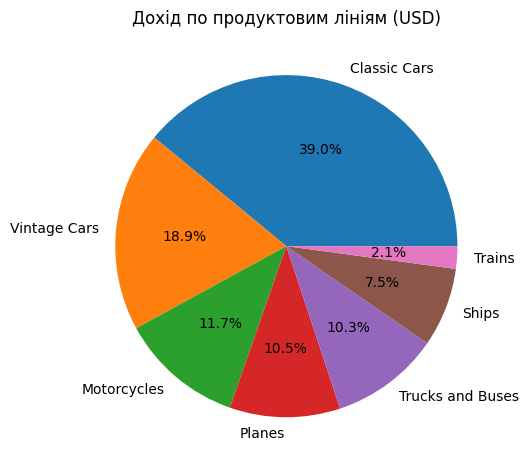

In [31]:
# 3.2 Візуалізація

# Стовпчикова діаграма - ТОП-5 країн
top_countries.plot(kind='bar', x='country', y='total_revenue', title='Доходи по країнах (USD)', legend=False)
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top_countries_revenue.png")
plt.show()

# Pie chart по продуктовим лініям
product_lines.set_index('productLine')['total_revenue'].plot.pie(autopct='%1.1f%%', title="Дохід по продуктовим лініям (USD)")
plt.ylabel('')
plt.tight_layout()
plt.savefig("product_lines_pie_chart.png")
plt.show()
